# Машинное обучение, ФКН ВШЭ

# Практическое задание 9. EM-алгоритм

## Общая информация

Дата выдачи: 18.02.2025

Мягкий дедлайн: 11.03.2025 23:59 MSK

Жёсткий дедлайн: 16.03.2025 23:59 MSK

## Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимальная оценка за работу (без учёта бонусов) — 15 баллов.

Сдавать задание после указанного жёсткого срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-09-em-Username.ipynb
* Модули preprocessing.py, metrics.py, models.py, содержащие написанный вами код
* Ссылки на посылки в Яндекс.Контест для всех функций и классов, которые вы реализовали

Ссылка на Яндекс.Контест: https://contest.yandex.ru/contest/60281

Username — ваша фамилия и имя на латинице именно в таком порядке

# Generative model of Labels, Abilities, and Difficulties (GLAD)

В [семинаре 16](https://github.com/esokolov/ml-course-hse/blob/master/2022-spring/seminars/sem16-em.pdf) мы рассмотрели задачу восстановления истинной разметки по меткам от экспертов (которым мы не можем доверять в полной мере, более того, их предсказания могут расходиться).

Рассмотрим следующую вероятностную модель:

$$ p(L, Z | \alpha, \beta) = \prod_{i=1}^{n} \prod_{j=1}^m \sigma(\alpha_j\beta_i)^{[l_{ij}=z_i]}\sigma(-\alpha_j\beta_i)^{1-[l_{ij}=z_i]} p(z_j)$$

где $l_{ij} -$ ответ $j$-го эксперта на задачу $i$, $z_j -$ истинная разметка, $\alpha_i, \beta_j-$ уровень экспертизы и сложность задачи соответственно. Для более подробного описания модели можно прочитать материалы семинара, а также [оригинальную статью](http://papers.nips.cc/paper/3644-whose-vote-should-count-more-optimal-integration-of-labels-from-labelers-of-unknown-expertise.pdf). Априорное распределение положим равномерным: $p(z_i) = 0.5$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
warnings.simplefilter('ignore')

seed = 0xDEADF00D
np.random.seed(seed)

In [2]:
L = np.load('L.npy')
n, m = L.shape

**Задание 1. (2 балла)** Реализуйте EM-алгоритм для заданной выше модели. Вы можете воспользоваться предложенными шаблонами или написать свои. 

Обратите внимание, что правдоподобие моделирует не вероятность метки $l_{ij}$ принять значение 1 или 0, а вероятность того, что она равна скрытой переменной $z_i$, т.е. $p(l_{ij} = z_j|z_j, \alpha_j, \beta_i) \neq p(l_{ij} = 1|\alpha_j, \beta_i) $. При этом заранее неизвестно, какая из скрытых переменных соответствует метке 1. Не забывайте, что параметры $\beta_i$ должны быть неотрицательными; для этого оптимизируйте $\log \beta$. На M-шаге можете использовать как один шаг градиентного спуска, так и несколько: разумные результаты у вас должны получаться вне зависимости от числа итераций.

Также при работе с вероятностями не забывайте о точности:
1. Используйте логарифмы вероятностей.
2. $\log \sigma(a)$ лучше преобразовать в $\log \sigma(a) = -\log(1 + \exp(-a)) = -\mathrm{softplus}(-a) $
3. Ещё полезные функции: `scipy.special.expit`, `scipy.special.logsumexp`, `np.log1p`

Для отладки может быть полезно проверить градиент с помощью `scipy.optimize.check_grad`.

In [3]:
from scipy.special import expit, logsumexp, softmax

In [4]:
def softplus(x):
    '''stable version of log(1 + exp(x))'''
    c = (x > 20) * 1.
    return np.log1p(np.exp(x * (1-c)) * (1-c)) + x * c

In [5]:
def posterior(alpha, beta, L):
    """ Posterior over true labels z p(z|l, \alpha, \beta)
    Args:
        alpha: ndarray of shape (n_experts).
        beta: ndarray of shape (n_problems).
        L: ndarray of shape (n_problems, n_experts).
    """
    p_z = 0.5 # поэтому можно не учитывать, оно просто сократится в формуле
    alpha_beta = alpha[None, :] * beta[:, None] # матрица из всех нужных произведений альф и бет
    gamma_0 = np.sum(-softplus(-alpha_beta) * (L == 0) + (-softplus(alpha_beta) * (L == 1)), axis = 1)
    gamma_1 = np.sum(-softplus(-alpha_beta) * (L == 1) + (-softplus(alpha_beta) * (L == 0)), axis = 1)
    q = softmax(np.array([gamma_0, gamma_1]).T, axis = 1)
    return q

def log_likelihood(alpha, beta, L, z):
    """ p(l=z|z, \alpha, \beta)
    Args:
        alpha: ndarray of shape (n_experts).
        beta: ndarray of shape (n_problems).
        L: ndarray of shape (n_problems, n_experts).
        z: ndarray of shape (n_problems).
    """
    pass


def alpha_grad_lb(alpha, beta, L, q):
    """ Gradient of lower bound wrt alpha
    Args:
        alpha: ndarray of shape (n_experts).
        beta: ndarray of shape (n_problems).
        L: ndarray of shape (n_problems, n_experts).
        q: ndarray of shape (2, n_problems).
    """
    alpha_beta = alpha[None, :] * beta[:, None]
    # считаем первую и вторую скобку из формул семинара в зависимости от t
    bracket_0 = expit(-alpha_beta)*(L==0) - expit(alpha_beta)*(L==1)
    bracket_1 = expit(-alpha_beta)*(L==1) - expit(alpha_beta)*(L==0)
    # дальше уже считаем градиент также по формуле 
    grad_alpha = (q[None, :, 0] * beta)[0][:, None] * bracket_0 + (q[None, :, 1] * beta)[0][:, None] * bracket_1
    grad_alpha = np.sum(grad_alpha, axis = 0)
    return grad_alpha

def logbeta_grad_lb(alpha, beta, L, q):
    """ Gradient of lower bound wrt alpha
    Args:
        alpha: ndarray of shape (n_experts).
        beta: ndarray of shape (n_problems).
        L: ndarray of shape (n_problems, n_experts).
        q: ndarray of shape (2, n_problems).
    """
    alpha_beta = alpha[None, :] * beta[:, None]
    bracket_0 = expit(-alpha_beta)*(L==0) - expit(alpha_beta)*(L==1)
    bracket_1 = expit(-alpha_beta)*(L==1) - expit(alpha_beta)*(L==0)
    grad_beta = q[None, :, 0][0][:, None] * (alpha * bracket_0) + q[None, :, 1][0][:, None] * (alpha * bracket_1)
    grad_beta = np.sum(grad_beta, axis = 1)
    return grad_beta

def lower_bound(alpha, beta, L, q):
    """ Lower bound
    Args:
        alpha: ndarray of shape (n_experts).
        beta: ndarray of shape (n_problems).
        L: ndarray of shape (n_problems, n_experts).
        q: ndarray of shape (2, n_problems).
    """
    pass


In [6]:
def em(L, n_steps=1000, lr=1e-3):
    # initialize parameters
    alpha, logbeta = np.random.randn(m), np.random.randn(n)

    for step in range(n_steps):
        # E-step
        q = posterior(alpha, np.exp(logbeta), L)
        
        # M-step
        for i in range(2):
            alpha_grad = alpha_grad_lb(alpha, logbeta, L, q)
            beta_grad = logbeta_grad_lb(alpha, logbeta, L, q)
            alpha = alpha + lr * alpha_grad
            logbeta = logbeta + lr * beta_grad

    return alpha, np.exp(logbeta), q

In [7]:
alpha, beta, q = em(L)

In [8]:
pred = q.argmax(axis = 1)

**Задание 2. (1 балл)** Загрузите настоящую разметку. Посчитайте `accuracy` разметки, полученной с помощью обычного голосования по большинству среди экспертов, и сравните его с качеством, полученным с помощью EM-алгоритма. Помните, что алгоритму не важно, какая метка 0, а какая 1, поэтому если получите качество <0.5, то просто поменяйте метки классов (не забудьте также поменять знак у $\alpha$). 

In [9]:
y = np.load('y.npy')

In [10]:
acc_em = (y == pred).mean()
print(f'Accuracy для разметки при помощи EM: {acc_em}')

Accuracy для разметки при помощи EM: 0.045


In [11]:
# меняем метки
pred = (pred == 0) * 1
alpha = -alpha

acc_em = (y == pred).mean()
print(f'Accuracy для разметки при помощи EM: {acc_em}')

Accuracy для разметки при помощи EM: 0.955


Как мы видим, качество получилось довольно хорошее, и заметно лучше голосования по большинству:

In [12]:
pred_maj = 1 * (L.mean(axis = 1) > 0.5)
acc_maj = (y == pred_maj).mean()
print(f'Accuracy для разметки при помощи голосования: {acc_maj}')

Accuracy для разметки при помощи голосования: 0.904


**Задание 3. (0.5 балла)** Попробуйте проинтерпретировать полученные коэфициенты $\alpha$. Есть ли в выборке эксперты, которые намеренно голосуют неверно? Как это можно понять по альфам? Продемонстрируйте, что эксперты действительно чаще голосуют за неверный класс. Постройте график зависимости доли врено размеченных экспертом объектов от коэффициента $\alpha$. Прокомментируйте результаты.

In [13]:
alpha # смотрим на коэффициенты

array([ 1.00984716,  1.19398232,  8.95990114,  0.86764911,  0.99376507,
        8.78002708,  0.99532861,  7.98926224, -8.39529352,  1.04481309,
       -8.97262766, -8.73871338,  8.45627468,  0.88890938,  1.03902083,
        0.85184644,  1.04010947,  8.21507661, -8.08438979,  8.12346125])

В общем мне кажется, что проверить можно так: возьмем максимальное значение альфы, это где-то 8.95. Получается, что это уровень экспертности самого крутого разметчика, который супер хорошо размечает данные. Тогда если взять эту альфу с отрицательным знаком, то получится супер глупый эксперт, который как будто специально размечает данные наоборот. И как мы видим, такие альфы действительно есть (например -8.97). Поэтому я бы сказал, что в выборке действительно есть эксперты, которые намеренно голосуют неверно.

In [14]:
acc = []
for i in range(len(alpha)):
    preds_i = L[:, i]
    acc_i = (preds_i == y).mean()
    acc.append(acc_i)
    
np.array(acc) # массив с долей верно размеченных объектов для каждого эксперта

array([0.697 , 0.709 , 0.919 , 0.6745, 0.6965, 0.917 , 0.686 , 0.9065,
       0.0905, 0.704 , 0.0825, 0.082 , 0.911 , 0.681 , 0.6835, 0.679 ,
       0.7015, 0.909 , 0.088 , 0.9105])

Как мы видим, среди экспертов на самом деле есть те, кто очень плохо размечает данные (доля верных разметок меньше 0.1). Посмотрим на зависимость этой доли от альфы:

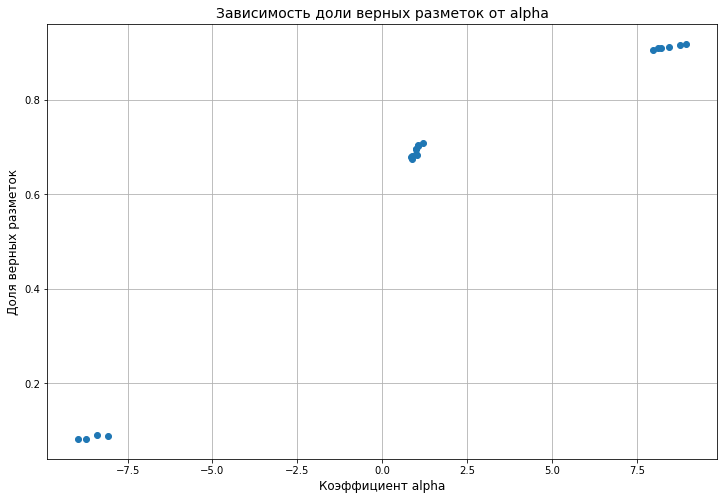

In [15]:
plt.figure(figsize = (12, 8))
plt.title('Зависимость доли верных разметок от alpha', fontsize = 14)
plt.xlabel('Коэффициент alpha', fontsize = 12)
plt.ylabel('Доля верных разметок', fontsize = 12)
plt.scatter(alpha, acc)
plt.grid()

Из графика видна разумная закономерность: чем больше альфа (то есть экспертность разметчика), тем выше доля верно размеченных объектов

**Задание 4. (бонус, 2 балла)**  Как уже было замечено выше, модели не важно, какой класс 1, а какой 0. Скажем, если все эксперты оказались максимально противными и ставят метку с точностью наоборот, то у вас будет полная согласованность между экспертами, при этом невозможно понять правильно они разметили выборку или нет, смотря только на такую разметку. Чтобы избежать этого, можно включать в выборку вопрос с заведомо известным ответом, тогда вы сможете определить, ставит ли эксперт специально неверные метки.

Чтобы обощить данную модель на случай заданий с заведомо известной меткой, достоточно не делать для них E-шаг, а всегда полагать апостериорное распределение вырожденным в истинном классе. Реализуйте данную модель и используйте истинную разметку *для нескольких* задач из обучения. Проинтерпретируйте полученные результаты.

In [16]:
tasks = [5, 777, 1990] # пусть мы знаем метки для трех этих задач

def posterior_new(alpha, beta, L, tasks = tasks, real_z = y[tasks]):
    """ Posterior over true labels z p(z|l, \alpha, \beta)
    Args:
        alpha: ndarray of shape (n_experts).
        beta: ndarray of shape (n_problems).
        L: ndarray of shape (n_problems, n_experts).
    """
    p_z = 0.5 # поэтому можно не учитывать, оно просто сократится в формуле
    alpha_beta = alpha[None, :] * beta[:, None]
    gamma_0 = np.sum(-softplus(-alpha_beta) * (L == 0) + (-softplus(alpha_beta) * (L == 1)), axis = 1)
    gamma_1 = np.sum(-softplus(-alpha_beta) * (L == 1) + (-softplus(alpha_beta) * (L == 0)), axis = 1)
    q = softmax(np.array([gamma_0, gamma_1]).T, axis = 1)
    
    # для известных задач оставляем настоящие метки (пропускаем E-шаг)
    # но приходится задавать наоборот, так как модель путает метки, и потом мы берем обратный прогноз
    q[tasks, 0] = 1 * (real_z == 1)
    q[tasks, 1] = 1 * (real_z == 0)
    return q

def em_new(L, n_steps=1000, lr=1e-3):
    alpha, logbeta = np.random.randn(m), np.random.randn(n)
    for step in range(n_steps):

        q = posterior_new(alpha, np.exp(logbeta), L)
        
        for i in range(2):
            alpha_grad = alpha_grad_lb(alpha, logbeta, L, q)
            beta_grad = logbeta_grad_lb(alpha, logbeta, L, q)
            alpha = alpha + lr * alpha_grad
            logbeta = logbeta + lr * beta_grad

    return alpha, np.exp(logbeta), q

In [17]:
alpha_new, beta_new, q_new = em_new(L)
pred_new = q_new.argmax(axis = 1)

In [18]:
acc_new = (y == pred_new).mean()
if acc_new < 0.5:
    acc_new = 1-acc_new
    alpha_new = -alpha_new
print(f'Accuracy разметки для нового EM : {acc_new}')

Accuracy разметки для нового EM : 0.9555


Как мы видим, accuracy немного выросло, видимо я добавил ответ для задачи, на которой мы раньше ошибались. Также можно увидеть что альфы увеличились по модулю. То есть модель лучше различает разметчиков по их экспертности (например, если бы у нас были 0.1 и -0.1 то между ними не было бы большой разницы)

In [19]:
alpha

array([ 1.00984716,  1.19398232,  8.95990114,  0.86764911,  0.99376507,
        8.78002708,  0.99532861,  7.98926224, -8.39529352,  1.04481309,
       -8.97262766, -8.73871338,  8.45627468,  0.88890938,  1.03902083,
        0.85184644,  1.04010947,  8.21507661, -8.08438979,  8.12346125])

In [20]:
alpha_new

array([ 1.02783716,  1.22314047,  9.10198456,  0.87981699,  1.01461586,
        8.91813854,  1.00695598,  8.12512343, -8.52861249,  1.06063237,
       -9.1136274 , -8.88139895,  8.59660295,  0.90029861,  1.05416117,
        0.86169737,  1.05472887,  8.35217309, -8.22170358,  8.25708395])

# Выравнивание слов (Word Alignment)

EM-алгоритм также применяют на практике для настройки параметров модели выравнивания слов, более сложные модификации которой используются в статистическом машинном переводе. Мы не будем подробно обсуждать применение word alignment для перевода и ограничимся следующей целью: пусть у нас есть параллельный корпус из предложений на исходном языке и их переводов на целевой язык (в этом задании используются английский и чешский соответственно). 

Первая задача — определить с помощью этого корпуса, как переводится каждое отдельное слово на целевом языке. Вторая задача — для произвольной пары из предложения и его перевода установить, переводом какого слова в исходном предложении является каждое слово в целевом предложении. Оказывается, у обеих задач существует элегантное и эффективное решение при введении правильной вероятностной модели: в этой части задания вам предстоит его реализовать и оценить результаты работы. Но обо всём по порядку :)

---

Перед тем, как заниматься машинным обучением, давайте разберёмся с данными и метриками в интересующей нас задаче. В ячейке ниже загружается и разархивируется параллельный английско-чешский корпус, в котором есть разметка выравнивания слов. Нетрудно заметить, что формат XML-файла, использованный его авторами, не вполне стандартный: нет готовой команды , которая позволила бы получить список пар предложений вместе с выравниваниями. Это значит, что нужно разобраться с форматом и написать парсер самостоятельно, используя встроенные средства Python, например, модуль [xml](https://docs.python.org/3.7/library/xml.html).

In [21]:
%%bash
wget -q https://lindat.mff.cuni.cz/repository/xmlui/bitstream/handle/11234/1-1804/CzEnAli_1.0.tar.gz -O CzEnAli_1.0.tar.gz
mkdir -p data
tar -xzf CzEnAli_1.0.tar.gz -C data/
head -n 20 data/merged_data/project_syndicate/project_syndicate_bacchetta1.wa

<?xml version="1.0" encoding="utf-8" ?>
<sentences>
<s id="project_syndicate_bacchetta1-s1">
  <english>Are the Dollar 's Days Numbered ?</english>
  <czech>Jsou dny dolaru sečteny ?</czech>
  <sure>1-1 3-3 5-2 6-4 7-5</sure>
  <possible>2-2 4-3</possible>
</s>
<s id="project_syndicate_bacchetta1-s2">
  <english>Philippe Bacchetta and Eric van Wincoop</english>
  <czech>Philippe Bacchetta and Eric van Wincoop</czech>
  <sure>1-1 2-2 3-3 4-4 5-5 6-6</sure>
  <possible></possible>
</s>
<s id="project_syndicate_bacchetta1-s3">
  <english>A year ago , the dollar bestrode the world like a colossus .</english>
  <czech>Ještě před rokem dolar dominoval světu jako imperátor .</czech>
  <sure>10-7 12-8 13-9 2-3 3-2 6-4 7-5 9-6</sure>
  <possible>1-3 11-8 3-1 5-4 8-6</possible>
</s>


**Задание -2. (0.5 балла)** Реализуйте функцию `extract_sentences`, которая принимает на вход путь к файлу с XML-разметкой, используемой в этом датасете, и возвращает список параллельных предложений, а также список из «уверенных» (sure) и «возможных» (possible) пар выравниваний. Отправьте вашу реализацию в Яндекс.Контест, чтобы убедиться в её корректности; в следующей ячейке ноутбука соберите все пары размеченных предложений из датасета в два списка `all_sentences` (список `SentencePair`) и `all_targets` (список LabeledAlignment).

Здесь и далее соблюдайте сигнатуры функций и пользуйтесь объявленными в модуле `preprocessing.py` классами для организации данных. Стоит заметить, что предложения уже токенизированы (даже отделена пунктуация), поэтому предобработку текстов совершать не нужно. Обратите внимание на формат хранения выравниваний: нумерация начинается с 1 (в таком виде и нужно сохранять), первым в паре идёт слово из англоязычного предложения.

При парсинге пользовался гайдом отсюда: https://docs.python.org/3/library/xml.etree.elementtree.html

In [22]:
%load_ext autoreload
%autoreload 2

In [23]:
import glob
from preprocessing import extract_sentences

all_sentences = []
all_targets = []
files = glob.glob('data/merged_data/**/*.wa', recursive=True)

for name in files:
    sentences_cur, targets_cur = extract_sentences(name)
    all_sentences.extend(sentences_cur)
    all_targets.extend(targets_cur)

In [24]:
all_sentences[:2]

[SentencePair(source=['Are', 'the', 'Dollar', "'s", 'Days', 'Numbered', '?'], target=['Jsou', 'dny', 'dolaru', 'sečteny', '?']),
 SentencePair(source=['Philippe', 'Bacchetta', 'and', 'Eric', 'van', 'Wincoop'], target=['Philippe', 'Bacchetta', 'and', 'Eric', 'van', 'Wincoop'])]

Ссылка на успешную посылку: https://contest.yandex.ru/contest/60281/run-report/134224131/

никнейм: ommirzoev@edu.hse.ru

**Задание -1. (0.5 балла)** Реализуйте функции `get_token_to_index` и `tokenize_sents` из модуля `preprocessing.py`, постройте словари token->index для обоих языков и постройте список из `TokenizedSentencePair` по выборке. Реализации функций также отправьте в Яндекс.Контест.

In [25]:
from preprocessing import get_token_to_index, tokenize_sents

t_idx_src, t_idx_tgt = get_token_to_index(all_sentences)
tokenized_sentences = tokenize_sents(all_sentences, t_idx_src, t_idx_tgt)

In [26]:
tokenized_sentences[:3]

[TokenizedSentencePair(source_tokens=array([0, 1, 2, 3, 4, 5, 6]), target_tokens=array([0, 1, 2, 3, 4])),
 TokenizedSentencePair(source_tokens=array([ 7,  8,  9, 10, 11, 12]), target_tokens=array([ 5,  6,  7,  8,  9, 10])),
 TokenizedSentencePair(source_tokens=array([13, 14, 15, 16,  1, 17, 18,  1, 19, 20, 21, 22, 23]), target_tokens=array([11, 12, 13, 14, 15, 16, 17, 18, 19]))]

Ссылка на успешную посылку: https://contest.yandex.ru/contest/60281/run-report/134250955/

никнейм: ommirzoev@edu.hse.ru

В качестве бейзлайна для этой задачи мы возьмём способ выравнивания слов по коэффициенту Дайса: слово в исходном языке является переводом слова на целевом языке, если они часто встречаются в одних и тех же предложениях и редко встречаются по отдельности. 

Математически это записывается по аналогии с мерой Жаккара: пусть $c(x,y)$ — число параллельных предложений, в которых есть и $x$ (на исходном языке), и $y$ (на целевом языке), а $c(x)$ и $c(y)$ — суммарное количество предложений, в которых встречается слово $x$ и $y$ соответственно. Тогда $\textrm{Dice}(x,y)=\frac{2 \cdot c(x,y)}{c(x) + c(y)}$ — характеристика «похожести» слов $x$ и $y$. Она равна 1, если слова встречаются только в контексте друг друга (не бывает предложений только со словом $x$ без $y$ в переводе и наоборот), равна 0, если слова никогда не встречаются в параллельных предложениях и находится между пороговыми значениями в остальных случаях.

В файле `models.py` описан абстрактный класс `BaseAligner`, наследником которого должны являться все модели в задании, а также приведён пример реализации `DiceAligner` выравнивания слов описанным выше путём. Ниже вы можете увидеть, как применять эту модель.

In [27]:
from models import DiceAligner

baseline = DiceAligner(len(t_idx_src), len(t_idx_tgt), threshold=0.01)
baseline.fit(tokenized_sentences)

Чтобы оценить качество модели выравнивания, пользуясь имеющейся разметкой, существует ряд автоматических метрик. Они подразумевают, что в разметке есть два вида выравниваний — «уверенные» (sure) и «возможные» (possible). Обозначим для конкретного предложения первое множество выравниваний $S$, второе — $P$, а предсказанные выравнивания — $A$; причём, в отличие от разметки в файле, $S\subseteq P$. Тогда можно предложить три метрики, используя только операции над этими множествами:

Precision $=\frac{|A\cap P|}{|A|}$. Отражает, какая доля предсказанных нами выравниваний вообще корректна; если мы дадим в качестве ответа все возможные пары слов в предложении, эта метрика сильно просядет.

Recall $=\frac{|A\cap S|}{|S|}$. Эта метрика показывает, какую долю «уверенных» выравниваний мы обнаружили. Если мы попытаемся сделать слишком консервативную модель, которая выдаёт 0 или 1 предсказание на нетривиальных предложениях, полнота получится крайне низкая. 

Alignment Error Rate (AER) $=1-\frac{|A\cap P|+|A\cap S|}{|A|+|S|}$. Метрика является комбинацией двух предыдущих и отслеживает общее качество работы системы, штрафуя оба описанных выше вида нежелаемого поведения модели. 

**Задание 0. (0.5 балла)** Реализуйте функции compute_precision, compute_recall, compute_aer из модуля metrics.py. Оцените качество бейзлайнового метода. Обратите внимание, что нужно использовать микро-усреднение во всех функциях: необходимо просуммировать числитель и знаменатель по всем предложениям и только потом делить.

In [28]:
from metrics import compute_aer

compute_aer(all_targets,baseline.align(tokenized_sentences))

0.8074618330841489

Ссылка на успешную посылку: https://contest.yandex.ru/contest/60281/run-report/134280648/

никнейм: ommirzoev@edu.hse.ru

Теперь мы можем перейти к базовой вероятностной модели для выравнивания слов. Пусть $S=(s_1,\ldots,s_n)$ исходное предложение, $T=(t_1,\ldots,t_m)$ — его перевод. В роли латентных переменных будут выступать выравнивания $A=(a_1,\ldots,a_m)$ каждого слова в целевом предложении, причём $a_i\in\{1,\ldots,n\}$ (считаем, что каждое слово в $t$ является переводом какого-то слова из $s$). Параметрами модели является матрица условных вероятностей перевода: каждый её элемент $\theta(y|x)=p(y|x)$ отражает вероятность того, что переводом слова $x$ с исходного языка на целевой является слово $y$ (нормировка, соответственно, совершается по словарю целевого языка). Правдоподобие латентных переменных и предложения на целевом языке в этой модели записывается так:

$$
p(A,T|S)=\prod_{i=1}^m p(a_i)p(t_i|a_i,S)=\prod_{i=1}^m \frac{1}{n}\theta(t_i|s_{a_i}).
$$ 

**Задание 1. (2 балла)** Выведите шаги EM-алгоритма для этой модели, а также получите выражение для подсчёта нижней оценки правдоподобия ($\mathcal{L}$ в обозначениях лекции и семинара). **Обратите внимание, что на M-шаге нужно найти аналитический максимум по параметрам.**

**E-step:**

на E-шаге нам нужно найти распределение на скрытых переменных:

$$
p(A|S,T) = \frac{p(A,T|S)}{p(T|S)} = \frac {\prod_{i=1}^m \frac{1}{n}\theta(t_i|s_{a_i})}{\sum_{A}\prod_{i=1}^m \frac{1}{n}\theta(t_i|s_{a_i})} 
$$

Теперь надо понять, как раскрывается сумма в знаменателе. Когда мы знаем выравнивание, то мы просто берем для каждого столбца подходящее слово на исходном языке (ищем по строчкам) и перемножаем m таких элементов. Но теперь нам надо проходиться по всем возможным выравниваниям для всех возможных таргетов, повторять эту процедуру и суммировать. То есть

$$ \sum_{A} = \sum_{a1}\sum_{a2}...$$ 

По сути, каждый элемент внутри столбца умножается на все остальные, кроме элементов своего столбца, то есть можно просто взять сумму по столбцам и потом перемножить. Типо:
$$ ac + ad + bc + bd = (a+b)(c+d)$$

Тогда 

$$
{\sum_{A}\prod_{i=1}^m \frac{1}{n}\theta(t_i|s_{a_i})} = \prod_{i=1}^m \sum_{k=1}^n \frac{1}{n}\theta(t_i|s_{k})
$$

И итоговая формула E-шага:

$$
p(A|S,T) = \frac {\prod_{i=1}^m \frac{1}{n}\theta(t_i|s_{a_i})}{ \prod_{i=1}^m \sum_{k=1}^n \frac{1}{n}\theta(t_i|s_{k})} = \prod_{i=1}^m \frac {\frac{1}{n}\theta(t_i|s_{a_i})}{\sum_{k=1}^n \frac{1}{n}\theta(t_i|s_{k})} = \prod_{i=1}^m \frac {\theta(t_i|s_{a_i})}{\sum_{k=1}^n \theta(t_i|s_{k})}
$$

Если мы предполагаем независимость там и все дела, то:

$$
q_i^* = \frac {\theta(t_i|s_{a_i})}{\sum_{k=1}^n \theta(t_i|s_{k})}
$$

**M-step:**

Найдя распределение q мы занулили KL-дивергенцию, поэтому теперь максимизируем нижнюю оценку:

$$
\mathcal{L} = \int q(A)\log \frac{p(A,T|S)}{q(A)}dA
$$

Интеграл берется по всем возможным значениям, поэтому надо проходиться по предложениям и всем выравниваниям там

$$
\mathcal{L} = \sum_{S,T}\sum_{a} q^*\log\prod_{i=1}^m\frac{\frac{1}{n}\theta(t_i|s_{a_i})}{q_i^*(a_i)} = 
\sum_{S,T}\sum_{a} q^*( \sum_{i=1}^m\log \frac{1}{n}\theta(t_i|s_{a_i}) - \log q_i(a_i)^*) = 
$$ 

$$
 =\sum_{S,T}\sum_{i=1}^m \sum_{j=1}^n q_i^*(j) \log \frac{1}{n}\theta(t_i|s_{j}) - \sum_{S,T}\sum_{i=1}^m\sum_{j=1}^n {q_i^*(j)}\log q_i^*(j) = 
$$

$$
\sum_{S,T}\sum_{i=1}^m \sum_{j=1}^n q_i^*(j) \log\theta(t_i|s_{j}) + \sum_{S,T} m\log\frac{1}{n} - \sum_{S,T}\sum_{i=1}^m\sum_{j=1}^n {q_i^*(j)}\log q_i^*(j)
$$

Максимизировать же нужно по параметрам поэтому два последних слагаемых можно отбросить

$$
\sum_{S,T}\sum_{i=1}^m \sum_{j=1}^n q_i^*(j) \log\theta(t_i|s_{j}) ->\max
$$

Максимизируем правдоподобие при условии ограничения (сумма вероятностей равна 1):

$$
L = \sum_{S,T}\sum_{i=1}^m \sum_{j=1}^n q_i^*(j) \log\theta(t_i|s_{j}) -\sum_S(\sum_T\theta(t|s) - 1) ->\max
$$

$$
L'_{\theta_i} = \sum_{S,T}\sum_{i=1}^m \frac{q_i^*(j)}{\theta(t_i|s_{j})} -\lambda_S = 0
$$

$$
\theta(t_i|s_{j}) = \frac{1}{\lambda_S}\sum_{S,T}\sum_{i=1}^m q_i^*(j) => \sum_{T}\frac{1}{\lambda_S}\sum_{S,T}\sum_{i=1}^m q_i^*(j) = 1 =>
$$

$$
=> \sum_{T}\frac{1}{\lambda_S}\sum_{S,T}\sum_{i=1}^m q_i^*(j) = 1 => \lambda_S = \sum_{T}\sum_{S,T}\sum_{i=1}^m q_i^*(j) 
$$

$$
\theta(t_i|s_{j}) = \frac{\sum_{S,T}\sum_{i=1}^m q_i^*(j)}{\sum_{T}\sum_{S,T}\sum_{i=1}^m q_i^*(j) }
$$


В формулах M-step пользовался GPT, так как окончательно в них запутался. Я закинул условие задания а также свою формулу E-step. Сначала он мне выдал какие-то непонятные формулы с индикаторами, пришлось повозиться с промптом. Также в формуле раскрытия ELBO он не учитывал константу $\sum_{S,T} m\log\frac{1}{n}$

В общем, сделав 5-6 повторных запросов и исправив его формулы получилось все-таки вывести правильную. Главное, что мне помогло это то, что я понял, что надо проходиться уже по всему корпусу и еще я понял, что надо оптимизировать лагранжиан а не просто нижнюю оценку

**Задание 2. (2.5 балла)** Реализуйте все методы класса `WordAligner` в соответствии с полученными вами формулами. Протестируйте вашу реализацию через Яндекс.Контест, а здесь обучите модель и посчитайте её AER на истинной разметке. Чтобы предсказать выравнивание для пары предложений в этой модели, следует выбирать в соответствие для слова в целевом предложении с индексом $i$ позицию, соответствующую максимуму апостериорного распределения $p(a_i|T,S)$.

17 посылок мне потребовалось, чтобы понять, что += не учитывает дубликаты в отличие от np.add.at :(

In [29]:
from models import WordAligner

word_aligner = WordAligner(len(t_idx_src), len(t_idx_tgt), 20)
word_aligner.fit(tokenized_sentences);

In [30]:
compute_aer(all_targets, word_aligner.align(tokenized_sentences))

0.5747378387000504

Ссылка на успешную посылку: https://contest.yandex.ru/contest/60281/run-report/135272743/

никнейм: ommirzoev@edu.hse.ru

Качество стало уже сильно лучше

Заметим, что таблицу вероятностей перевода можно использовать и саму по себе для построения словарей. Пример работы показан ниже: метод хоть и работает, но мягко говоря, неидально — слишком мало данных.

In [31]:
idx_token_tgt = {index:token for token, index in t_idx_tgt.items()}

In [32]:
[idx_token_tgt[i] for i in word_aligner.translation_probs[t_idx_src['Mr']].argsort()[-3:]]

['Pan', 'řekl', 'pan']

In [33]:
[idx_token_tgt[i] for i in word_aligner.translation_probs[t_idx_src['Mrs']].argsort()[-3:]]

['-', 'Mannová', 'paní']

In [34]:
[idx_token_tgt[i] for i in word_aligner.translation_probs[t_idx_src['water']].argsort()[-3:]]

['z', 'pro', 'vody']

In [35]:
[idx_token_tgt[i] for i in word_aligner.translation_probs[t_idx_src['depended']].argsort()[-3:]]

['jež', 'překupničením', 'koni']

In [36]:
[idx_token_tgt[i] for i in word_aligner.translation_probs[t_idx_src['on']].argsort()[-3:]]

['.', 'se', 'na']

**Задание 3. (0.5 балла)** Мы смогли получить матрицу условных вероятностей перевода исходного языка в целевой. Можно ли, пользуясь этой матрицей и ещё какими-то статистиками по параллельному корпусу, получить вероятности перевода целевого языка в исходный? Реализуйте такой метод и приведите ниже пример его работы, показав пару удачных переводов.

$$
\theta(s|t)=\frac{\theta(s,t)}{\theta(t)} = \frac{\theta(t|s)\theta(s)}{\theta(t)}
$$

Получается, что новую матрицу можно получить из старой с учетом $\theta(t)$ и $\theta(s)$. По сути, это вероятности встретить слово (на исходном языке для s и на целевом для t). Их можно определить просто как сколько раз встретилось слово поделить на общее число слов

In [37]:
probs_t = np.zeros(len(t_idx_tgt))
probs_s = np.zeros(len(t_idx_src))
for el in tokenized_sentences:
    np.add.at(probs_s, el.source_tokens, 1)
    np.add.at(probs_t, el.target_tokens, 1)
probs_t /= probs_t.sum()
probs_s /= probs_s.sum()

probs_reverse = ((word_aligner.translation_probs * probs_s.reshape(-1, 1)) / probs_t).T

Можем посмотреть прям на те же слова, только уже с чешского на английский:

In [38]:
idx_token_src = {index:token for token, index in t_idx_src.items()}

[idx_token_src[i] for i in probs_reverse[t_idx_tgt['záviselo']].argsort()[-3:]]

['disorganized', 'depended', 'haggling']

In [39]:
[idx_token_src[i] for i in probs_reverse[t_idx_tgt['vody']].argsort()[-3:]]

['volume', 'reimmersion', 'water']

In [40]:
[idx_token_src[i] for i in probs_reverse[t_idx_tgt['letadlo']].argsort()[-3:]] # летадло - самолет, прикол:)

['737', 'supposed', 'plane']

**Задание 4. (0.5 балла)** Визуализируйте полученные выравнивания для нескольких предложений в виде heatmap: по одной из осей располагаются токены исходного текста, по другой — токены его перевода, на пересечении позиций $i$ и $j$ — 0 либо 1 в зависимости от того, является ли в обученной модели $a_i$ равным $j$. Можете ли вы их проинтерпретировать? Постройте аналогичный график, но без дискретизации, а визуализируя напрямую апостериорное распределение. Можете ли вы найти ситуации, в которых модель не уверена, переводом какого слова является слово $i$?

In [41]:
examples = word_aligner.align(tokenized_sentences[100:102])
# функция, которая составляет датасет из нужной матрицы 
def get_df(alignment):
    sources = []
    targets = []
    for el in alignment:  # составляем списки уникальных токенов для предложения 
        if el[0] not in sources:
            sources.append(el[0])
        if el[1] not in targets:
            targets.append(el[1])

    align_matrix = np.zeros((len(sources), len(targets))) # нужная нам матрица, если пара встретилась в 
    for i in range(len(sources)):                         # выравнивании, ставим 1
        for j in range(len(targets)):
            if (sources[i], targets[j]) in alignment:
                align_matrix[i, j] += 1
    df = pd.DataFrame(align_matrix, columns = [[idx_token_tgt[i] for i in targets]], 
                index = [[idx_token_src[i] for i in sources]])
    return df

df_1 = get_df(examples[0])
df_2 = get_df(examples[1])

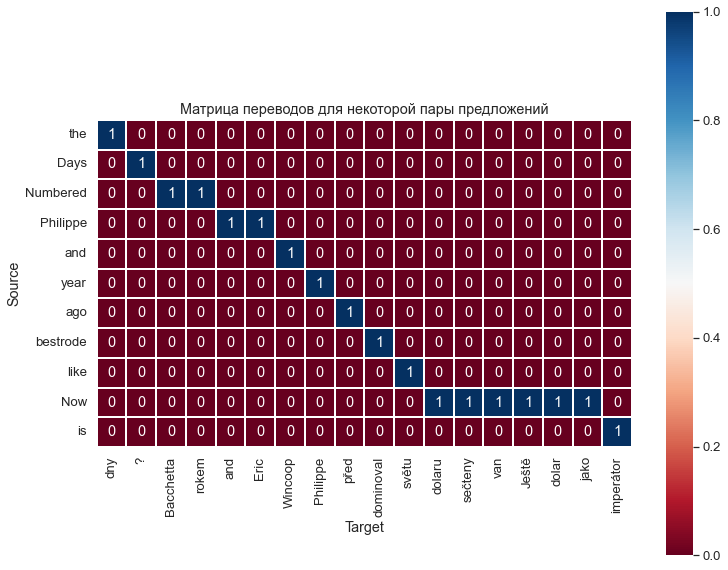

In [42]:
plt.figure(figsize = (12, 10))
sns.set(font_scale = 1.2)

sns.heatmap(df_1, square=True, annot=True, linewidths=0.4, cmap="RdBu").set(
            title = 'Матрица переводов для некоторой пары предложений',
            xlabel = 'Target', ylabel = 'Source');

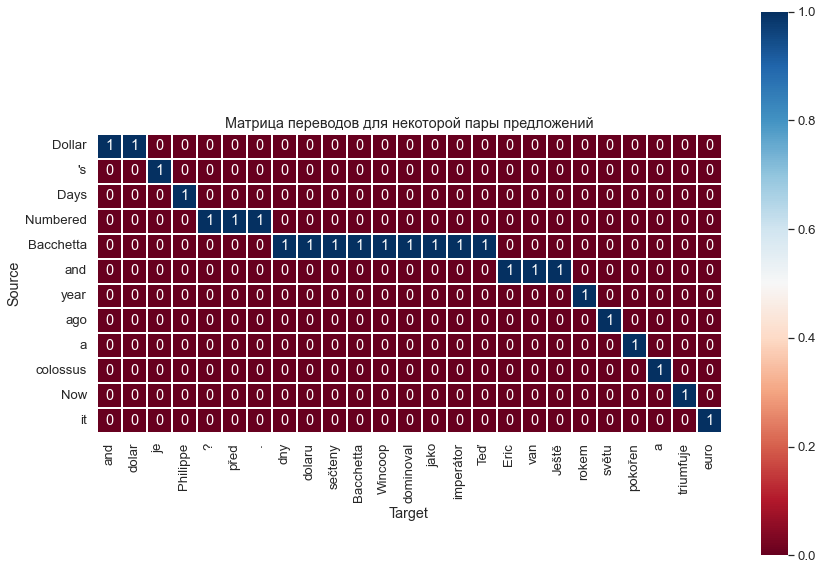

In [43]:
plt.figure(figsize = (14, 10))
sns.set(font_scale = 1.2)

sns.heatmap(df_2, square=True, annot=True, linewidths=0.4, cmap="RdBu").set(
            title = 'Матрица переводов для некоторой пары предложений',
            xlabel = 'Target', ylabel = 'Source');

На самом деле интерпретировать это дело немного сложно. Вроде все как и должно быть, модель берет слово на чешском и находит для него наиболее вероятный перевод среди представленных. Единственное, можно заметить, что часто слов на чешском языке больше чем на английском, поэтому кажется, что модель распределяет слова, в которых больше уверенна, а потом выбирает какое-то одно слово на английском, которому ставит в соответствие все оставшиеся слова из чешского языка. Также посмотрим на апостериорное распределение:

In [44]:
def get_df_posterior(alignment):
    sources = []
    targets = []
    for el in alignment:
        if el[0] not in sources:
            sources.append(el[0])
        if el[1] not in targets:
            targets.append(el[1])

    align_matrix = word_aligner.translation_probs[np.array(sources)[:, None], np.array(targets)]
    df = pd.DataFrame(align_matrix, columns = [[idx_token_tgt[i] for i in targets]], 
                index = [[idx_token_src[i] for i in sources]])
    return df
df_1 = get_df_posterior(examples[0])
df_2 = get_df_posterior(examples[1])

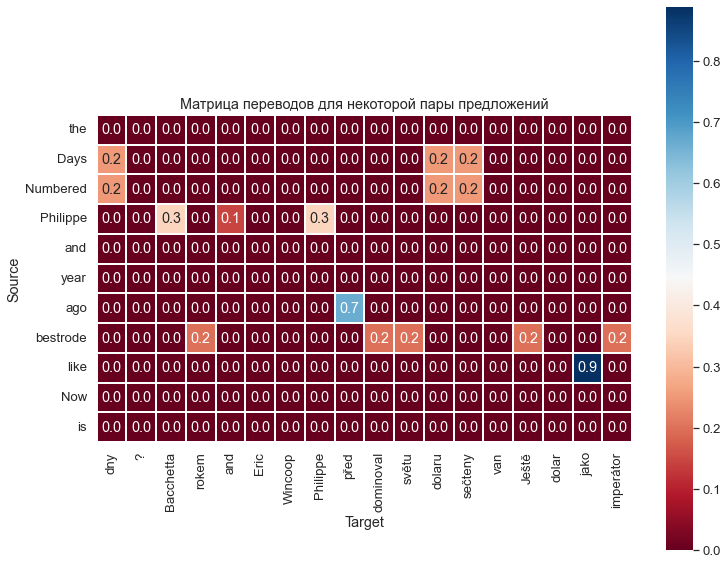

In [45]:
plt.figure(figsize = (12, 10))
sns.set(font_scale = 1.2)

sns.heatmap(df_1, square=True, annot=True, fmt=".1f", linewidths=0.4, cmap="RdBu").set(
            title = 'Матрица переводов для некоторой пары предложений',
            xlabel = 'Target', ylabel = 'Source');

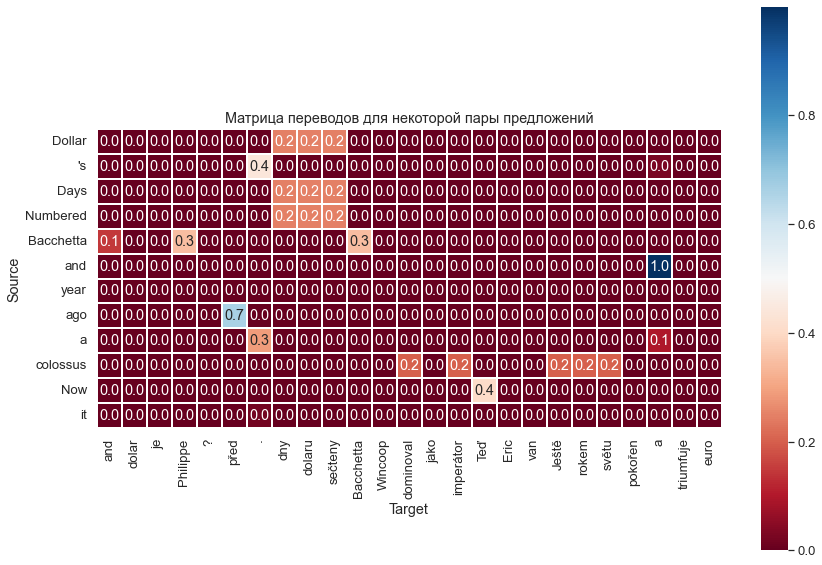

In [46]:
plt.figure(figsize = (14, 10))
sns.set(font_scale = 1.2)

sns.heatmap(df_2, square=True, annot=True, fmt=".1f", linewidths=0.4, cmap="RdBu").set(
            title = 'Матрица переводов для некоторой пары предложений',
            xlabel = 'Target', ylabel = 'Source');

Как мы видим, действительно часто встречаются ситуации, где модель неуверенна. Возьмем последний график, для слов Days и Numbered есть по три слова на чешском языке с одинаковой вероятностью перевода, ну и таких примеров много.

Заметим, что при задании модели мы сделали довольно сильное предположение о том, что вероятности выбора слова для выравнивания никак не зависят от позиции слова в целевом предложении. Можно сделать эти вероятности настраиваемыми параметрами, получив прямоугольную матрицу $\phi_{m,n}(j|i)=p(a_i=j|m,n)$ для каждой пары длин предложений $m,n$: по-прежнему мы получаем распределение над индексами в исходном предложении. Тогда модель приобретает вид
$$
p(A,T|S)=\prod_{i=1}^m p(a_i|m,n)p(t_i| a_i, S)=\prod_{i=1}^m \phi_{m,n}(a_i|i)\theta(t_i|s_{a_i}).
$$

**Задание 5. (1.5 балла)** Выведите шаги EM-алгоритма для этой модели, а также получите выражение для подсчёта нижней оценки правдоподобия.

Блин, это так интересно, но я просто не успеваю :( Успел только unicode-нормализацию

**Задание 6. (2 балла)** Реализуйте все методы класса `WordPositionAligner`, протестируйте их корректность через Яндекс.Контест. Обучите модель, оцените её качество на истинной разметке и сравните его с качеством предыдущей более простой модели. Проиллюстрируйте влияние стартовых параметров на результат, проинициализировав эту модель параметрами модели из задания 2 (важно, чтобы суммарное число эпох обучения в обоих сценариях оставалось тем же).

In [ ]:
from models import WordPositionAligner
# (≧ ◡ ≦)━★☆.*･｡ﾟ

**Задание 7. (1 балл)** В предыдущих пунктах мы никак не заостряли внимание на предобработке текстов, что может негативно влиять на результаты обученной модели. Например, сейчас метод выравнивания учитывает регистр, а слова на чешском языке вдобавок обладают богатой морфологией и большим количеством диакритических знаков. Если сократить количество параметров модели (различных слов), можно ускорить обучение и добиться лучших результатов, потому что статистики по словам будут считаться по большему числу параллельных предложений.

Примените к исходным данным [Unicode-нормализацию](https://en.wikipedia.org/wiki/Unicode_equivalence#Normalization), приведите их к нижнему регистру и обучите модель выравнивания заново. Сравните качество и скорость обучения с предыдущими результатами и сделайте выводы. Если вы найдете в данных ещё какие-то проблемы, которые можно исправить более грамотной предобработкой, также продемонстрируйте, как их решение влияет на качество.

**Важно:** здесь и далее в процессе обработки данных у вас может получаться, что из тестовых данных будут удалены предложения из-за отсутствия слов в словаре. Если такое всё же произошло, для корректности сравнения считайте AER вашей модели на удалённых предложениях равным 1.

In [47]:
import unicodedata
def transform_word(word): # Функция для преобразования слов
    new_word = ''
    normalized = unicodedata.normalize('NFD', word)
    for letter in normalized:
        if unicodedata.combining(letter) == 0:
            new_word += letter
    return new_word

In [48]:
import copy
all_sentences_new = copy.deepcopy(all_sentences)
for pair in range(len(all_sentences_new)):
    for s in range(len(all_sentences_new[pair].source)):
        all_sentences_new[pair].source[s] = transform_word(all_sentences_new[pair].source[s]).lower()
    for t in range(len(all_sentences_new[pair].target)):
        all_sentences_new[pair].target[t] = transform_word(all_sentences_new[pair].target[t]).lower()
all_sentences_new[:2]

[SentencePair(source=['are', 'the', 'dollar', "'s", 'days', 'numbered', '?'], target=['jsou', 'dny', 'dolaru', 'secteny', '?']),
 SentencePair(source=['philippe', 'bacchetta', 'and', 'eric', 'van', 'wincoop'], target=['philippe', 'bacchetta', 'and', 'eric', 'van', 'wincoop'])]

In [49]:
t_idx_src_new, t_idx_tgt_new = get_token_to_index(all_sentences_new)
tokenized_sentences_new = tokenize_sents(all_sentences_new, t_idx_src_new, t_idx_tgt_new)

word_aligner_new = WordAligner(len(t_idx_src_new), len(t_idx_tgt_new), 20)
word_aligner_new.fit(tokenized_sentences_new);
compute_aer(all_targets, word_aligner_new.align(tokenized_sentences_new))

0.5577989770821112

In [50]:
len(all_sentences_new), len(all_sentences)

(2501, 2501)

Качество действительно улучшилось, а число предложений не изменилось

**Задание 7. (бонус, до 3 баллов)** 

Улучшите качество получившейся системы настолько, насколько сможете. За каждые 5 процентов, на которые AER на тех же данных получается меньше, чем минимум ошибки всех предыдущих моделей, вы получите по 1 бонусному баллу.

Ниже приведены несколько идей, которые могут помочь вам повысить 

* Модифицировать модель: как вы можете понять, недостатком второго реализованного вами подхода является избыточное число параметров из-за необходимости подерживать отдельную матрицу для каждой различной пары длин предложений в корпусе. В статье https://www.aclweb.org/anthology/N13-1073.pdf приведён способ снижения числа параметров, задающих априорное распределение позиций выравнивания, который позволяет в десять раз быстрее обучать модель и получать лучшее качество.
* Агрегация по двум направлениям: в статье https://www.aclweb.org/anthology/J03-1002/ утверждается, что асимметричность выравниваний вредит качеству, потому что из-за выбранной модели одному слову в целевом предложении не может соответствовать два слова в исходном предложении. Для решения этой проблемы (и улучшения метрик, разумеется) авторы предлагают несколько алгоритмов, которые можно попробовать применить в этом задании.
* Использовать больше обучающих данных. В корпусе, которым мы пользуемся, только пара тысяч предложений, чего может не хватать для по-настоящему хорошей модели выравнивания. Разумеется, неразмеченных параллельных английско-чешских корпусов гораздо больше, поэтому можно воспользоваться ими. Хорошая точка для старта — данные с соревнования по машинному переводу  [воркшопа WMT](http://www.statmt.org/wmt20/translation-task.html).
* В языках часто существуют слова наподобие артиклей или предлогов, которым не соответствует ни одно слово в переводе. Все рассмотренные в рамках задания модели это не учитывают, возможно, добавление возможности перевода в «нулевой» токен улучшит качество модели (при тестировании такие выравнивания имеет смысл выбрасывать)

In [ ]:
# ┐_(ツ)_┌━☆ﾟ.*･｡ﾟ